### This notebook is used to model global sea surface temperature as well as in the arctic and antarctic regions. The dataset used to look a this information spans from January 2015 to December 2100, and is accompanied by another dataset that can be used to spatially weigh the sea surface temperature data.
##### Resources in this notebook are largely supplied by Dr. Beadling, and assembled by Colin Krzystek

In [16]:
from matplotlib import pyplot as plt
import matplotlib.path as mpath   ## needed for nice looking polar projections.
import numpy as np
import pandas as pd
import xarray as xr
import zarr  # to read in Zarr format
import gcsfs # to read google cloud data
import momlevel as ml
import cftime

In [2]:
xr.set_options(display_style='html')
%matplotlib inline                           
%config InlineBackend.figure_format='retina' 
plt.rcParams['figure.figsize'] = 12,6  

### The code in the cell below reads in climate model results stored in the Google Cloud from the GFDL-ESM4 Earth System Model developed at NOAA's Geophysical Fluid Dynamics Laboratory (GFDL). The results are monthly sea surface temperature from the high-emissions future scenario, SSP5-85. A grid cell area file is also loaded in.

In [3]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
OISST_landsea_mask = xr.open_dataset('/home/ees_student/Krzystek_Unit5/data/lsmask.nc')

In [4]:
gfdl_esm4_sst_data = df.query(
    "activity_id=='ScenarioMIP' & \
    table_id == 'Omon' & \
    variable_id == 'tos' & \
    experiment_id == 'ssp585' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4' & \
    grid_label == 'gn' & \
    member_id == 'r1i1p1f1'"
)

# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')
# get the path to a specific zarr store (the first one from the dataframe above)
zstore_sst = gfdl_esm4_sst_data.zstore.values[-1]
# create a mutable-mapping-style interface to the store
mapper_sst = gcs.get_mapper(zstore_sst)
# open the dataset using xarray and zarr
gfdl_esm4_historical_sst = xr.open_zarr(mapper_sst, 
                                         consolidated=True,use_cftime=True
                                         ).tos.rename({'y':'latitude',
                                                             'x':'longitude',
                                                             'lat':'geolat',
                                                             'lon':'geolon'})
gfdl_esm4_historical_sst

<xarray.DataArray 'tos' (time: 1032, latitude: 576, longitude: 720)>
dask.array<open_dataset-tos, shape=(1032, 576, 720), dtype=float32, chunksize=(64, 576, 720), chunktype=numpy.ndarray>
Coordinates:
    geolat     (latitude, longitude) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolon     (latitude, longitude) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * longitude  (longitude) float64 -299.8 -299.2 -298.8 ... 58.75 59.25 59.75
  * latitude   (latitude) float64 -77.91 -77.72 -77.54 ... 89.47 89.68 89.89
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    long_name:      Sea Surface Temperature
    original_name:  tos
    standard_name:  sea_surface_temperature
    units:          degC

In [5]:
gfdl_esm4_cell_area_data = df.query(
    "activity_id=='CMIP' & \
    table_id == 'Ofx' & \
    variable_id == 'areacello' & \
    experiment_id == 'piControl' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4' & \
    grid_label == 'gn'")

# get the path to a specific zarr store (the first one from the dataframe above)
zstore_area = gfdl_esm4_cell_area_data.zstore.values[-1]
# create a mutable-mapping-style interface to the store
mapper_area = gcs.get_mapper(zstore_area)
# open the dataset using xarray and zarr
gfdl_esm4_cell_area = xr.open_zarr(mapper_area, 
                                         consolidated=True,
                                         ).areacello.rename({'y':'latitude',
                                                             'x':'longitude',
                                                             'lat':'geolat',
                                                             'lon':'geolon'})
gfdl_esm4_cell_area

<xarray.DataArray 'areacello' (latitude: 576, longitude: 720)>
dask.array<open_dataset-areacello, shape=(576, 720), dtype=float32, chunksize=(576, 720), chunktype=numpy.ndarray>
Coordinates:
    geolat     (latitude, longitude) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    geolon     (latitude, longitude) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
  * longitude  (longitude) float64 -299.8 -299.2 -298.8 ... 58.75 59.25 59.75
  * latitude   (latitude) float64 -77.91 -77.72 -77.54 ... 89.47 89.68 89.89
Attributes:
    cell_methods:   area: sum
    long_name:      Grid-Cell Area
    original_name:  areacello
    standard_name:  cell_area
    units:          m2

### In the cells below, produce an analysis that assesses and quantifies the change in area-weighted global average SST, arctic SST, antarctic SSTs. Your analysis must consider different timescales (monthly, annual, seasonal etc). You must include figures in your analysis and a description of the spatial patterns you observe.

### Your spatial plots should utilize `geolon` and `geolat` to remove the distortion in the polar regions .... https://mom6-analysiscookbook.readthedocs.io/en/latest/notebooks/Plotting.html

# Global Average SST Annually

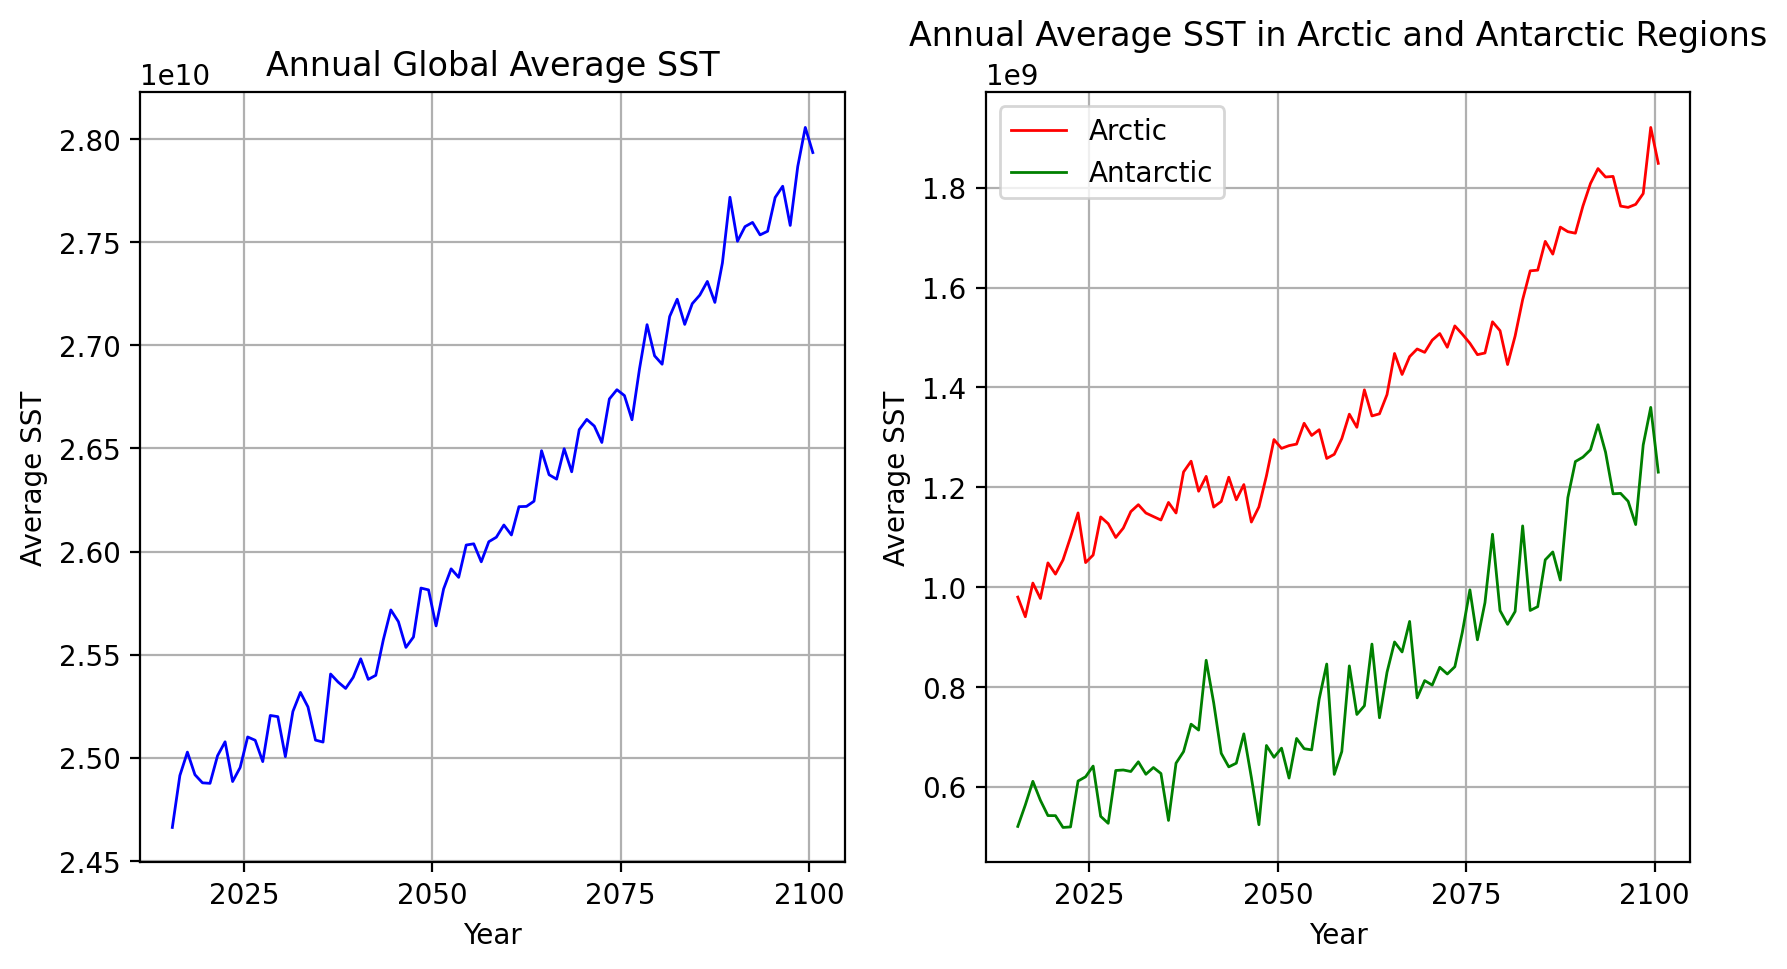

In [6]:
weighted_average_SST1 = (gfdl_esm4_historical_sst*gfdl_esm4_cell_area).mean(['latitude', 'longitude']) #Spatially weighting the SST data
weighted_average_SST = ml.util.annual_average(weighted_average_SST1,tcoord='time')

arctic = gfdl_esm4_historical_sst.sel(latitude=slice(55,90))
arctic_average_SST1 = (arctic*gfdl_esm4_cell_area).mean(['latitude', 'longitude']) #Spatially weighting the SST data
arctic_average_SST = ml.util.annual_average(arctic_average_SST1,tcoord='time')

antarctic = gfdl_esm4_historical_sst.sel(latitude=slice(-90,-55))
antarctic_average_SST1 = (antarctic*gfdl_esm4_cell_area).mean(['latitude', 'longitude']) #Spatially weighting the SST data
antarctic_average_SST = ml.util.annual_average(antarctic_average_SST1,tcoord='time')

fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2, figsize = (10, 5))  #plotting the data
weighted_average_SST.plot(ax=ax0, #global on the left chart
        linewidth=1,label='Global Average SST',
        color='blue')
arctic_average_SST.plot(ax=ax1, #arctic on the right chart
        linewidth=1,label='Arctic',
        color='red')
antarctic_average_SST.plot(ax=ax1,  #antarctic on the right chart
        linewidth=1,label='Antarctic',
        color='green')

ax0.set_title('Annual Global Average SST')
ax1.set_title('Annual Average SST in Arctic and Antarctic Regions')
## add axes labes:
ax0.set_ylabel('Average SST')
ax0.set_xlabel('Year')
ax1.set_ylabel('Average SST')
ax1.set_xlabel('Year')

ax0.grid(linestyle='-')
ax1.grid(linestyle='-')
ax1.legend()

**Figure 1.** Time series of modeled Sea Surface Temperature (SST) a) globally and b) in the polar regions for the whole 21st century, with arctic SST in redand antarctic SST in green. This figure was produced using GFDL-ESM4 SST model output for the years 2015-2100 as well as the GFDL-ESM4 model grid cell area to spatially weigh the data.

# Global Average SST Seasonally

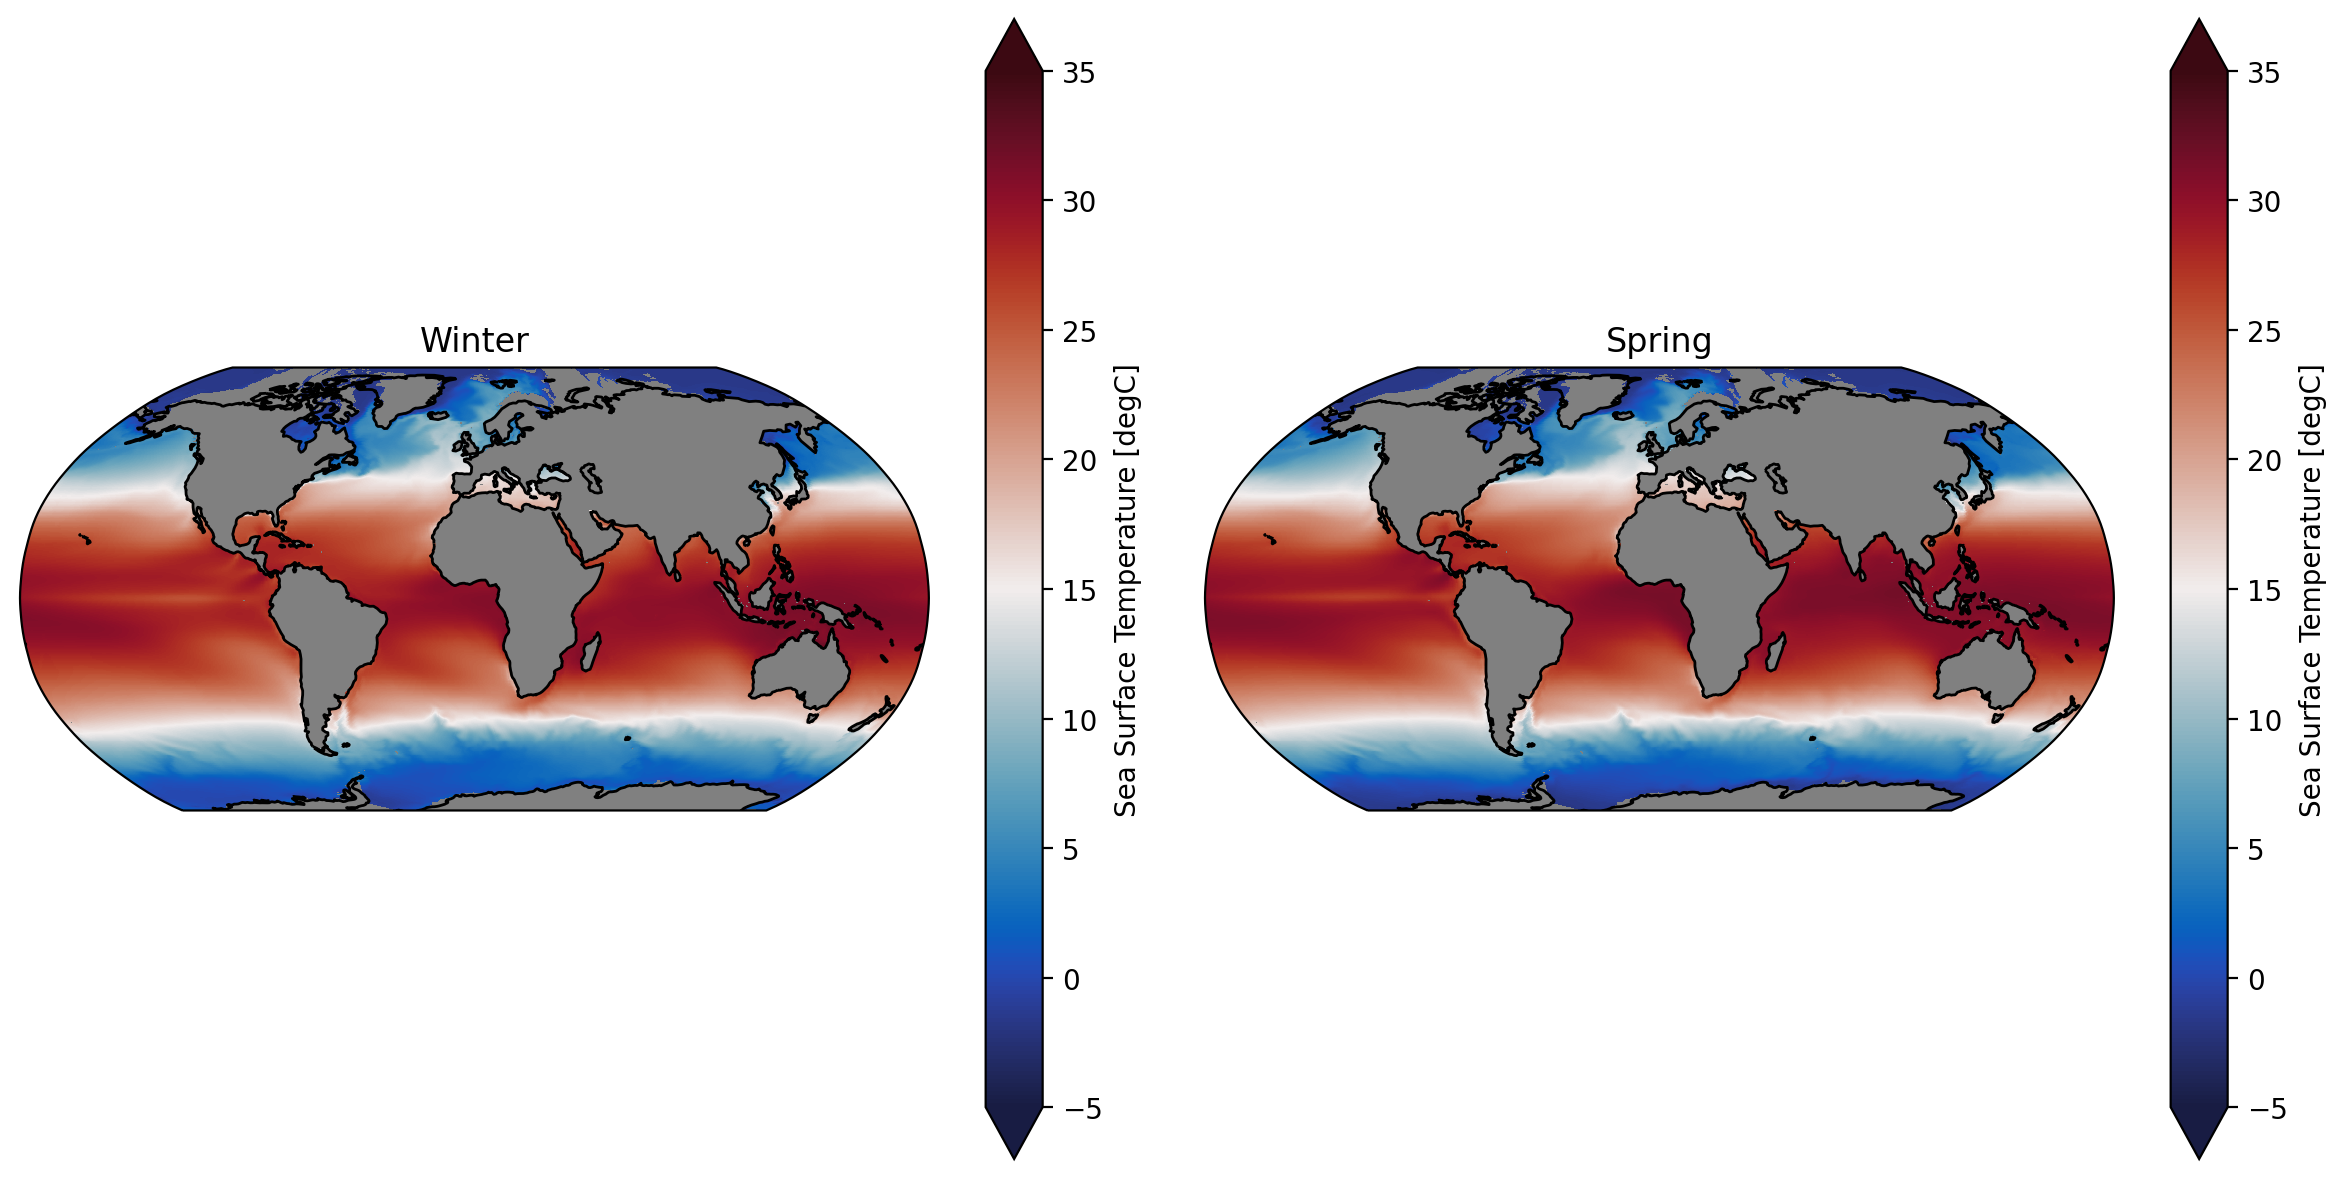

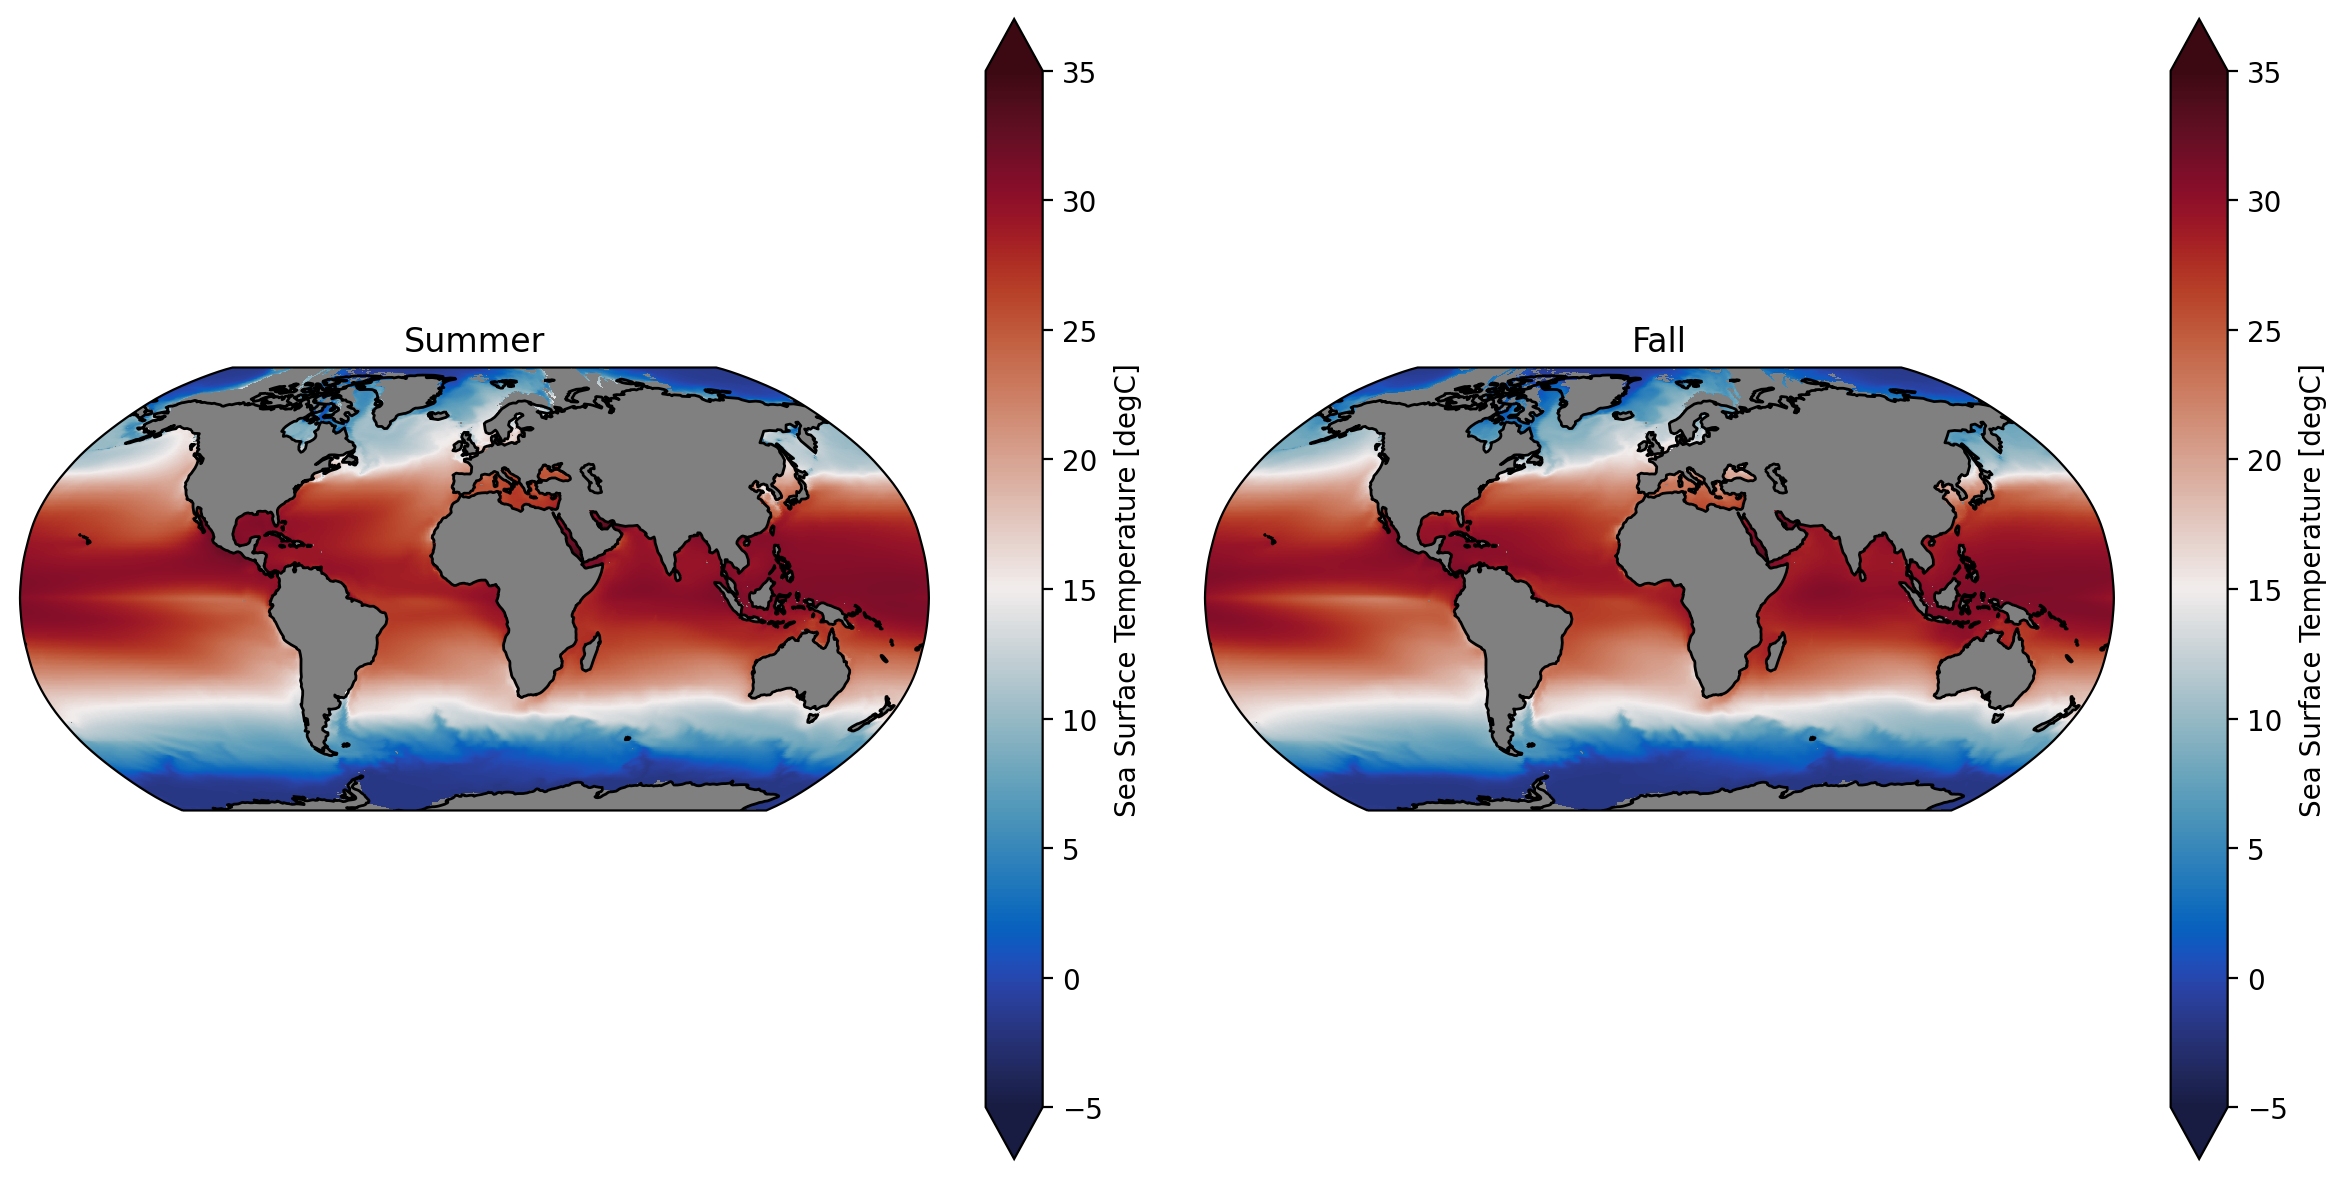

In [11]:
SST_seasons = gfdl_esm4_historical_sst.groupby('time.season').mean(dim='time')  #averaging over each season
DJF = SST_seasons.sel(season='DJF')  #creating names for each individual season
MAM = SST_seasons.sel(season='MAM')
JJA = SST_seasons.sel(season='JJA')
SON = SST_seasons.sel(season='SON')

import cmocean
import cartopy.crs as ccrs
subplot_kws=dict(projection=ccrs.Robinson(),
                 facecolor='grey')
fig, (ax0,ax1) = plt.subplots(nrows = 1, ncols = 2, subplot_kw = subplot_kws)
#plotting the first two seasons in one figure
DJF.plot( ax=ax0,
            cmap=cmocean.cm.balance,
            vmin=-5,vmax=35, 
         extend='both',
             transform= ccrs.PlateCarree())
MAM.plot( ax=ax1,
            cmap=cmocean.cm.balance,
            vmin=-5,vmax=35, 
         extend='both',
             transform= ccrs.PlateCarree())
plt.tight_layout()
ax0.set_title('Winter')
ax1.set_title('Spring')
ax0.coastlines()
ax1.coastlines()

fig, (ax0,ax1) = plt.subplots(nrows = 1, ncols = 2, subplot_kw = subplot_kws)
#plotting the second two seasons on another figure
JJA.plot( ax=ax0,
            cmap=cmocean.cm.balance,
            vmin=-5,vmax=35, 
         extend='both',
             transform= ccrs.PlateCarree())
SON.plot( ax=ax1,
            cmap=cmocean.cm.balance,
            vmin=-5,vmax=35,
         extend='both',
             transform= ccrs.PlateCarree())
plt.tight_layout()
ax0.set_title('Summer')
ax1.set_title('Fall')
ax0.coastlines()
ax1.coastlines()

**Figure 2.** Global Projections of the modeled Sea Surface Temperature (SST) for all four seasons averaged over the years 2015-2100. This figure was produced using the GFDL-ESM4 SST model output for the years 2015-2100.

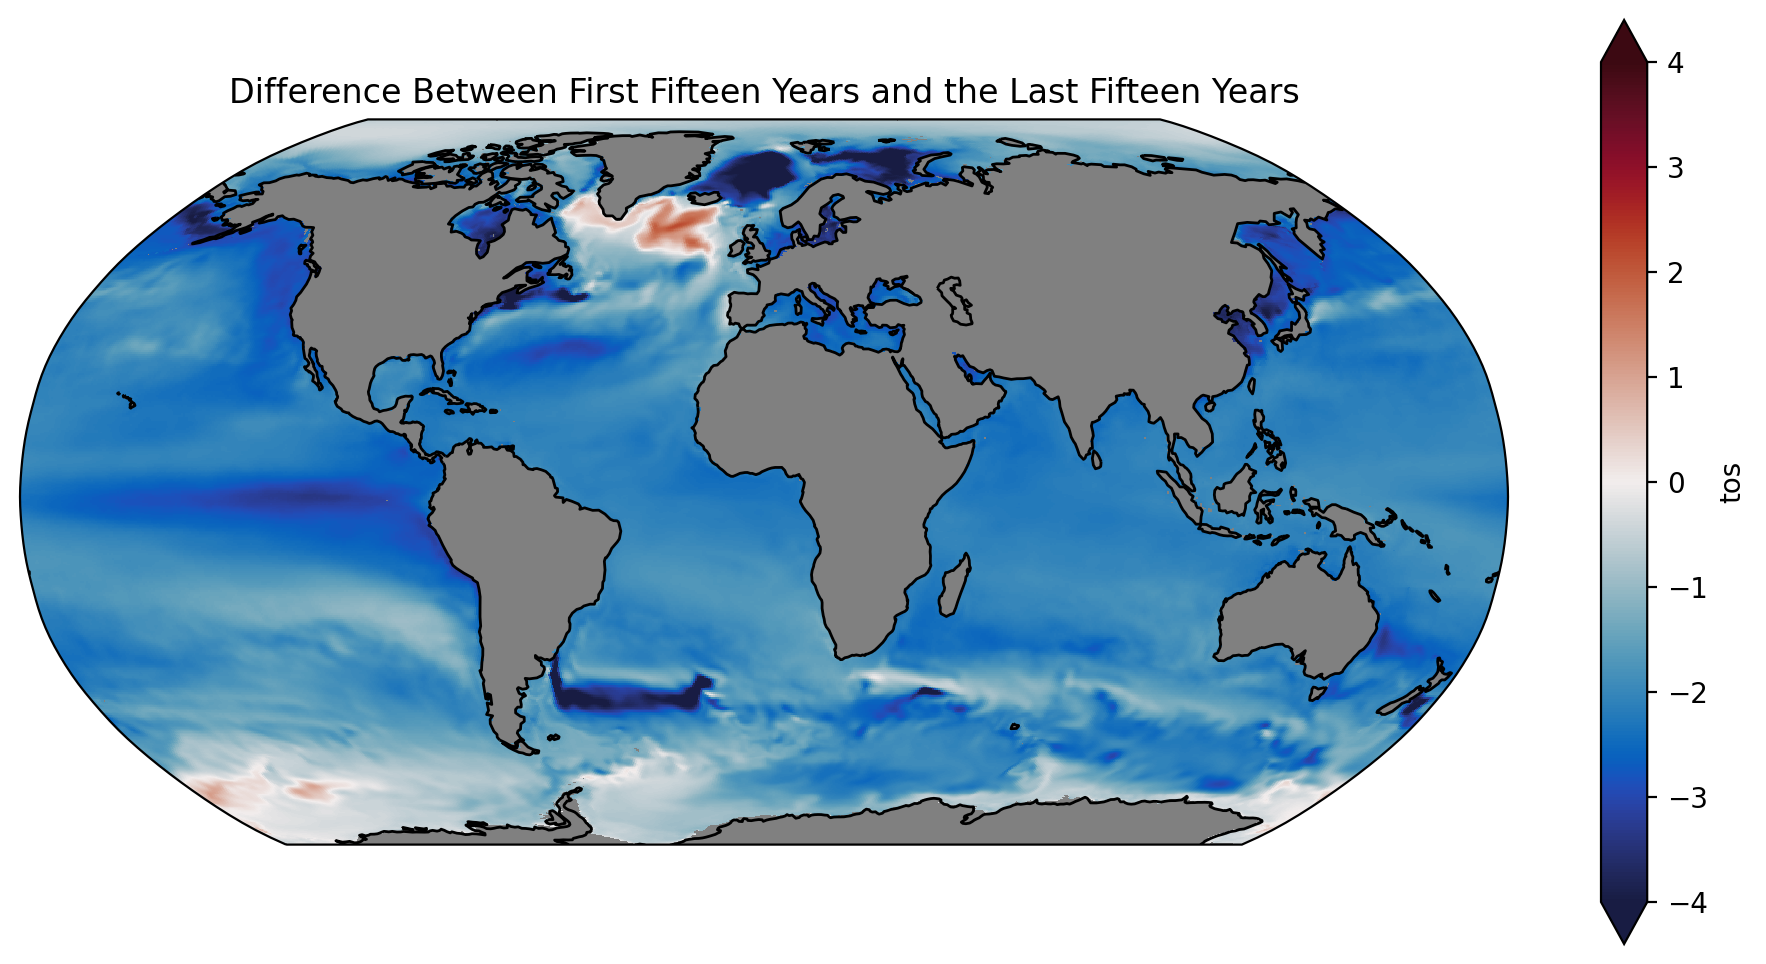

In [12]:
SST_last5 = gfdl_esm4_historical_sst.sel(time=slice('2015-01-01','2029-12-01'))  #slicing out the start of the century
SST_first5 = gfdl_esm4_historical_sst.sel(time=slice('2086-01-01','2100-12-01'))  #slicing out the end of the century

SST_last5_annual = ml.util.annual_cycle(SST_last5,tcoord='time')  #Averaging over each month
SST_first5_annual = ml.util.annual_cycle(SST_first5,tcoord='time')  #Averaging over each month

SST_last5_average = ml.util.annual_average(SST_last5_annual,tcoord='time').squeeze()  #Averaging over each year
SST_first5_average = ml.util.annual_average(SST_first5_annual,tcoord='time').squeeze()   #Averaging over each year

Difference = SST_last5_average - SST_first5_average #taking the difference between the start and end of the century

fig, ax = plt.subplots(subplot_kw = subplot_kws)
#plotting that difference
Difference.plot( ax=ax, x='geolon', y='geolat',
            cmap=cmocean.cm.balance,
            vmin=-4,vmax=4, extend='both',
             transform= ccrs.PlateCarree())

ax.set_title('Difference Between First Fifteen Years and the Last Fifteen Years')
ax.coastlines()

**Figure 3.** Global projection of the difference between the average of the end of the century global SST and the start of the century global SST. This figure was produced using the GFDL-ESM4 SST model output for the years 2015-2100.

In [14]:
def North_Polar(array,vmin,vmax,cmap):
    subplot_kws = dict(projection=ccrs.NorthPolarStereo()) 
    fig, ax = plt.subplots(figsize=[10, 5],subplot_kw=subplot_kws)
    
    array.plot(ax=ax,x='geolon', y='geolat',
               transform =ccrs.PlateCarree(),
               vmin=vmin,
               vmax=vmax,
               extend='both',
               cmap=cmap,levels=30)

    # Limit the map to -50 degrees latitude and below.
    ax.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
    
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)
    ax.coastlines()

In [18]:
def South_Polar(array,vmin,vmax,cmap):
    subplot_kws = dict(projection=ccrs.SouthPolarStereo()) 
    fig, ax = plt.subplots(figsize=[10, 5],subplot_kw=subplot_kws)
    
    array.plot(ax=ax,x='geolon', y='geolat',
               transform =ccrs.PlateCarree(),
               vmin=vmin,
               vmax=vmax,
               extend='both',
               cmap=cmap, levels=30)

    # Limit the map to -50 degrees latitude and below.
    ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)
    ax.coastlines()

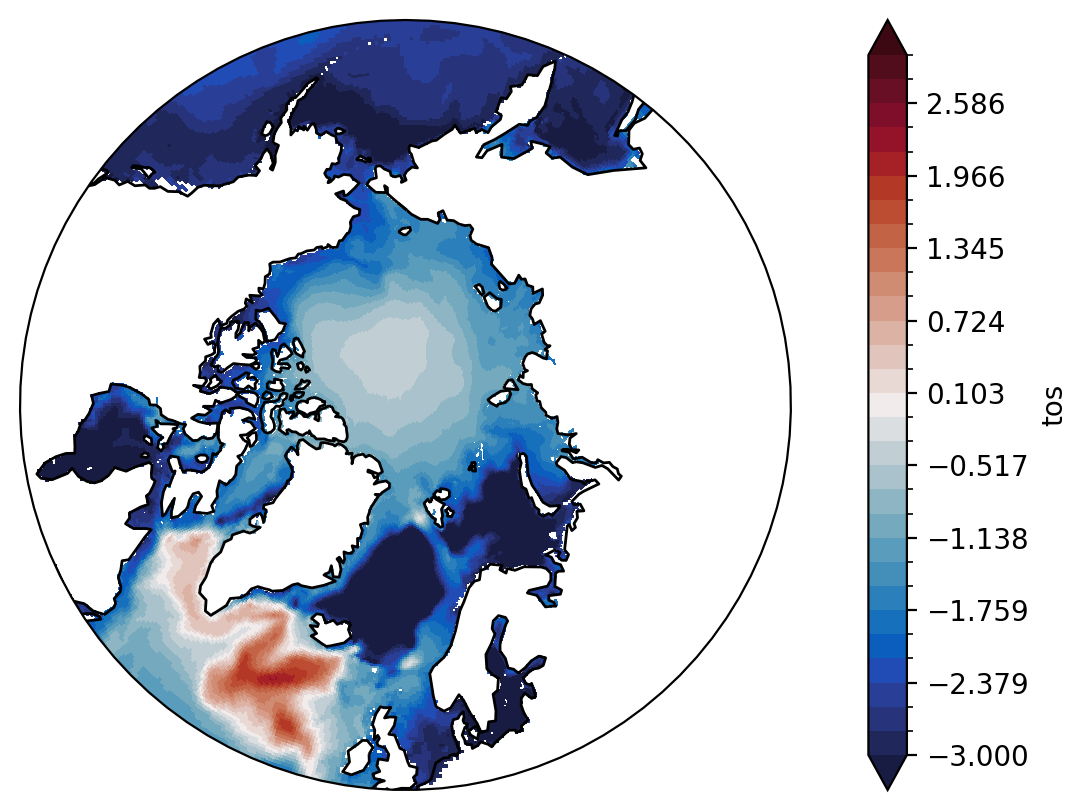

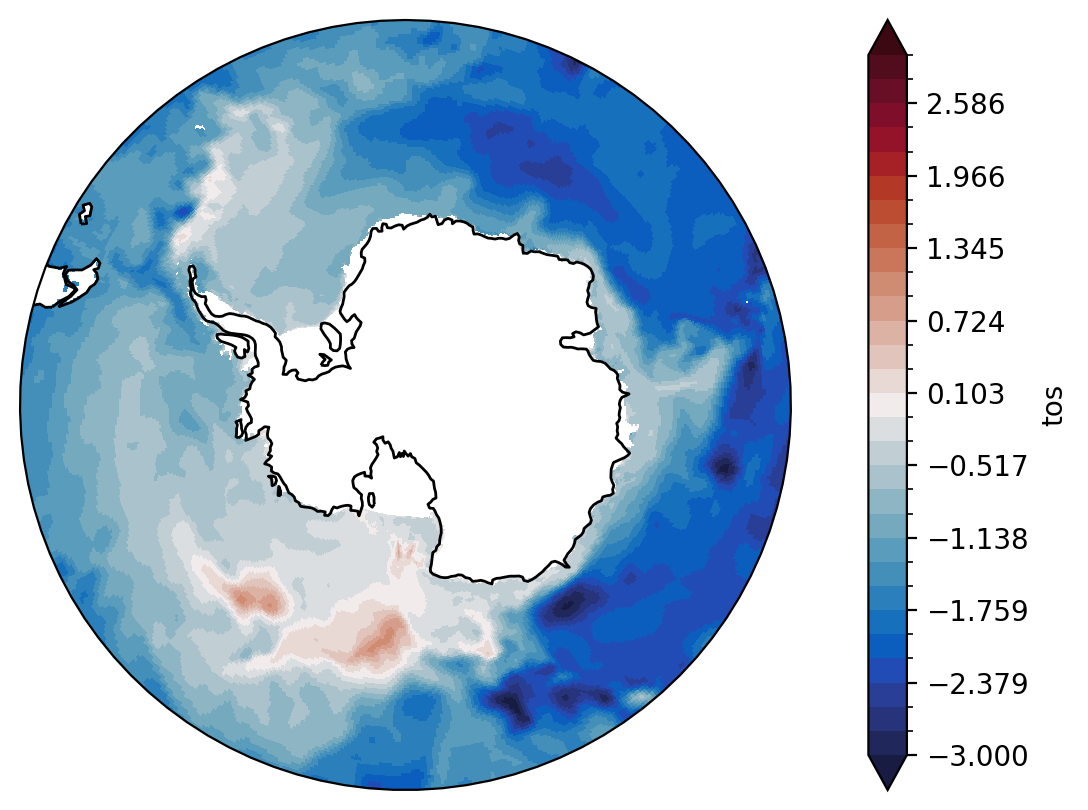

In [19]:
SST_last5 = gfdl_esm4_historical_sst.sel(time=slice('2015-01-01','2029-12-01')) #slicing out the start of the century
SST_first5 = gfdl_esm4_historical_sst.sel(time=slice('2086-01-01','2100-12-01')) #slicing out the end of the century

SST_last5_annual = ml.util.annual_cycle(SST_last5,tcoord='time') #averaging over each month
SST_first5_annual = ml.util.annual_cycle(SST_first5,tcoord='time') #averaging over each month

SST_last5_average = ml.util.annual_average(SST_last5_annual,tcoord='time').squeeze()  #averaging over each year
SST_first5_average = ml.util.annual_average(SST_first5_annual,tcoord='time').squeeze()  #averaging over each year
Difference = SST_last5_average - SST_first5_average  #Taking the difference between the start and end of the century

ant_SST_last5 = gfdl_esm4_historical_sst.sel(time=slice('2015-01-01','2029-12-01'))  #Slicing out the start of the century for the antarctic region
ant_SST_first5 = gfdl_esm4_historical_sst.sel(time=slice('2086-01-01','2100-12-01'))  #Slicing out the end of the century for the antarctic region

ant_SST_last5_annual = ml.util.annual_cycle(ant_SST_last5,tcoord='time')  #averaging over each month
ant_SST_first5_annual = ml.util.annual_cycle(ant_SST_first5,tcoord='time')  #averaging over each month

ant_SST_last5_average = ml.util.annual_average(ant_SST_last5_annual,tcoord='time').squeeze()  #averaging over each year
ant_SST_first5_average = ml.util.annual_average(ant_SST_first5_annual,tcoord='time').squeeze()  #averaging over each year
ant_Difference = ant_SST_last5_average - ant_SST_first5_average  #taking the difference between the start and end of the century

North_Polar(Difference,-3,3,cmocean.cm.balance)
South_Polar(ant_Difference,-3,3,cmocean.cm.balance)

**Figure 4.** Polar projections of the difference between the average of the end of the century global SST and the start of the century global SST. a) Difference in SST in the arctic region b) Difference in SST in the antarctic region. This figure was produced using the GFDL-ESM4 SST model output for the years 2015-2100.

We've now looked at past, present, and future SST data and can logically infer the direction that SST is headed. Nearly every graph in the notebook describes SST to be increasing at a steady rate throughout the rest of the 21st century. This may not be reflected as harshly in polar regions, however this is where the most damage can be done, as rising SST there will eventually diminish our sea ice which is holding much of our fresh water, and will make sea levels rise. 